In [ ]:
# Set seeds for reproducibility
import random
random.seed(0)
import numpy as np
np.random.seed(0)
import tensorflow as tf
tf.random.set_seed(0)

import os
import json
from zipfile import ZipFile
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
kaggle_credentails=json.load(open('kaggle.json'))

In [ ]:
# setup kaggle API key as enviroment variables
os.environ['KAGGLE_USERNAME']=kaggle_credentails['username']
os.environ['KAGGLE_KEY']=kaggle_credentails['key']

In [ ]:
!kaggle datasets download -d abdallahalidev/plantvillage-dataset

Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
100% 2.04G/2.04G [01:34<00:00, 23.5MB/s]
100% 2.04G/2.04G [01:34<00:00, 23.1MB/s]


In [ ]:
!ls

kaggle.json  plantvillage-dataset.zip  sample_data


In [ ]:
# Unzip the downloaded dataset
with ZipFile('plantvillage-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
print(os.listdir("plantvillage dataset"))

print(len(os.listdir("plantvillage dataset/segmented")))
print(os.listdir("plantvillage dataset/segmented")[:5])

print(len(os.listdir("plantvillage dataset/color")))
print(os.listdir("plantvillage dataset/color")[:5])

print(len(os.listdir("plantvillage dataset/grayscale")))
print(os.listdir("plantvillage dataset/grayscale")[:5])

['segmented', 'grayscale', 'color']
38
['Raspberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Orange___Haunglongbing_(Citrus_greening)', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Grape___Esca_(Black_Measles)']
38
['Raspberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Orange___Haunglongbing_(Citrus_greening)', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Grape___Esca_(Black_Measles)']
38
['Raspberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Orange___Haunglongbing_(Citrus_greening)', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Grape___Esca_(Black_Measles)']


In [ ]:
print(len(os.listdir("plantvillage dataset/color/Grape___healthy")))
print(os.listdir("plantvillage dataset/color/Grape___healthy")[:5])

423
['75ad9d58-7f7e-4a4c-8ced-fec8d23d9a7e___Mt.N.V_HL 6170.JPG', '2d1327cf-7a91-4baf-b3b6-42517c795c9c___Mt.N.V_HL 6171.JPG', 'a4158d4f-b9f2-49e8-8dbe-02c619685624___Mt.N.V_HL 6042.JPG', '0708190e-d6a1-4186-8428-1cd816419bfd___Mt.N.V_HL 9017.JPG', '7042c2f6-b859-41ec-8ee0-b058f9e9e906___Mt.N.V_HL 6164.JPG']


In [ ]:
# Dataset Path
base_dir='plantvillage dataset/color'

(256, 256, 3)


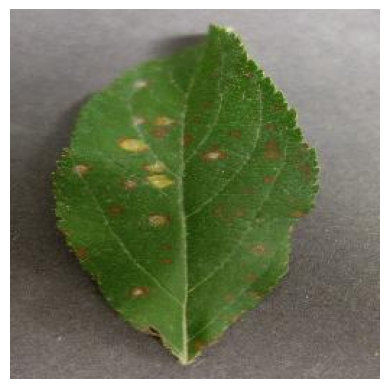

In [ ]:
image_path="/content/plantvillage dataset/color/Apple___Cedar_apple_rust/052e3deb-0499-4685-bc39-cea7f1df0700___FREC_C.Rust 3742.JPG"
# Read the image
img=mpimg.imread(image_path)

print(img.shape)
# Display the image
plt.imshow(img)
plt.axis('off') # Turn off axes numbers
plt.show()

In [ ]:
# Image Parameters
img_size = 299  # InceptionV3 requires input size of 299x299
batch_size = 32

# Image Data Generators
data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Use 20% of data for validation
)

# Train Generator
train_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Validation Generator
validation_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Load the InceptionV3 model with pre-trained weights
inception_v3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the layers of InceptionV3 to prevent them from being trained
for layer in inception_v3.layers:
    layer.trainable = False

# Add custom layers on top of InceptionV3
x = inception_v3.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(train_generator.num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=inception_v3.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('best_model_inception.keras', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10,
    callbacks=[checkpoint, early_stopping]
)

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

# Save the final model
model.save('plant_disease_classifier_inception.keras')

Found 43456 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 252s 168ms/step - accuracy: 0.4771 - loss: 2.0217 - val_accuracy: 0.8738 - val_loss: 0.4384
Epoch 2/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0099
Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 240s 169ms/step - accuracy: 0.8191 - loss: 0.6027 - val_accuracy: 0.9095 - val_loss: 0.2915
Epoch 4/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 37s 27ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 1.4781e-04
Epoch 5/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 216s 159ms/step - accuracy: 0.8724 - loss: 0.4069 - val_accuracy: 0.9306 - val_loss: 0.2228
Epoch 6/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 35us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.1950
Epoch 7/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 265s 161ms/step - accuracy: 0.8993 - loss: 0.3181 - val_accuracy: 0.9354 - val_loss: 0.1998
Epoch 8/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.1032
Epoch 9/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 22